## Breast Histopathology Images: Image Classification

Dataset Source: https://huggingface.co/datasets/EulerianKnight/breast-histopathology-images-train-test-valid-split

#### Install Necessary Libraries

In [1]:
%pip install torch datasets
%pip install transformers evaluate
%pip install accelerate -U
%pip install peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 96.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.7 MB/s eta 0:00:00


#### Import Necessary Libraries

In [2]:
import os, sys, random, shutil
os.environ['TOKENIZERS_PARALLELISM']='false'

from PIL import ImageDraw, ImageFont, Image
import PIL.Image

from tqdm import tqdm

import numpy as np
import pandas as pd

import datasets
from datasets import load_dataset, Image, DatasetDict, ClassLabel

import transformers
from transformers import Trainer, TrainingArguments
from transformers import ViTForImageClassification, ViTImageProcessor

import torch
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

import peft
from peft import LoraConfig, get_peft_model

import evaluate

!git lfs install

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.


#### Enter HuggingFace Access Token

In [3]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


##### Display Versions of Relevant Libraries

In [4]:
print("Python :".rjust(15), sys.version[0:6])
print("NumPy :".rjust(15), np.__version__)
print("Pandas :".rjust(15), pd.__version__)
print("Datasets :".rjust(15), datasets.__version__)
print("Evaluate :".rjust(15), evaluate.__version__)
print("Transformers :".rjust(15), transformers.__version__)
print("Torch :".rjust(15), torch.__version__)
print("PEFT :".rjust(15), torch.__version__)

       Python : 3.10.1
        NumPy : 1.22.4
       Pandas : 1.5.3
     Datasets : 2.13.1
     Evaluate : 0.4.0
 Transformers : 4.30.2
        Torch : 2.0.1+cu118
         PEFT : 2.0.1+cu118


##### Ingest Dataset

In [5]:
data = load_dataset("EulerianKnight/breast-histopathology-images-train-test-valid-split")

data = data.rename_column("label", "labels")

data

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/EulerianKnight___imagefolder/EulerianKnight--breast-histopathology-images-train-test-valid-split-f7dfbd5bdc449945/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 277000
    })
})

#### Split Dataset into Training/Testing/Evaluation Datasets & Display Basic Information About Datasets

In [6]:
train_testvalid = data['train'].train_test_split(test_size=0.40)
test_valid = train_testvalid['test'].train_test_split(test_size=0.50)

ds = DatasetDict({
    'train' : train_testvalid['train'],
    'test' : test_valid['test'],
    'eval' : test_valid['train']
})

print("Training dataset shape:", ds['train'].shape)
print("Validation dataset shape:", ds['eval'].shape)
print("Testing dataset shape:", ds['test'].shape)

Training dataset shape: (166200, 2)
Validation dataset shape: (55400, 2)
Testing dataset shape: (55400, 2)


#### Display Information About Dataset

In [7]:
print('Training data shape:', ds['train'].shape)
print('Testing data shape:', ds['test'].shape)
print('Validation data shape:', ds['eval'].shape)

print(f"\nTraining Dataset Features: \n{ds['train'].features}")

Training data shape: (166200, 2)
Testing data shape: (55400, 2)
Validation data shape: (55400, 2)

Training Dataset Features: 
{'image': Image(decode=True, id=None), 'labels': ClassLabel(names=['0', '1'], id=None)}


##### Display Grid of Examples From Each Class to Gain Better Picture of Data

In [8]:
def show_grid_of_examples(ds,
                          seed: int = 42,
                          examples_per_class: int = 3,
                          size=(350, 350)):
    '''
    This function displays a few pictures
    from each class in the dataset.
    '''
    w, h = size
    labels = ds['train'].features['labels'].names
    grid = PIL.Image.new(mode='RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)

    for label_id, label in enumerate(labels):
        # filter the dataset by a single label, shuffle it, then grab a few samples
        ds_slice = ds['train'] \
                    .filter(lambda ex: ex['labels'] == label_id) \
                    .shuffle(seed) \
                    .select(range(examples_per_class))

        # plot this label's examples in a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), dill=(0,0,255,1.0))

    return grid

Filter:   0%|          | 0/166200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/166200 [00:00<?, ? examples/s]

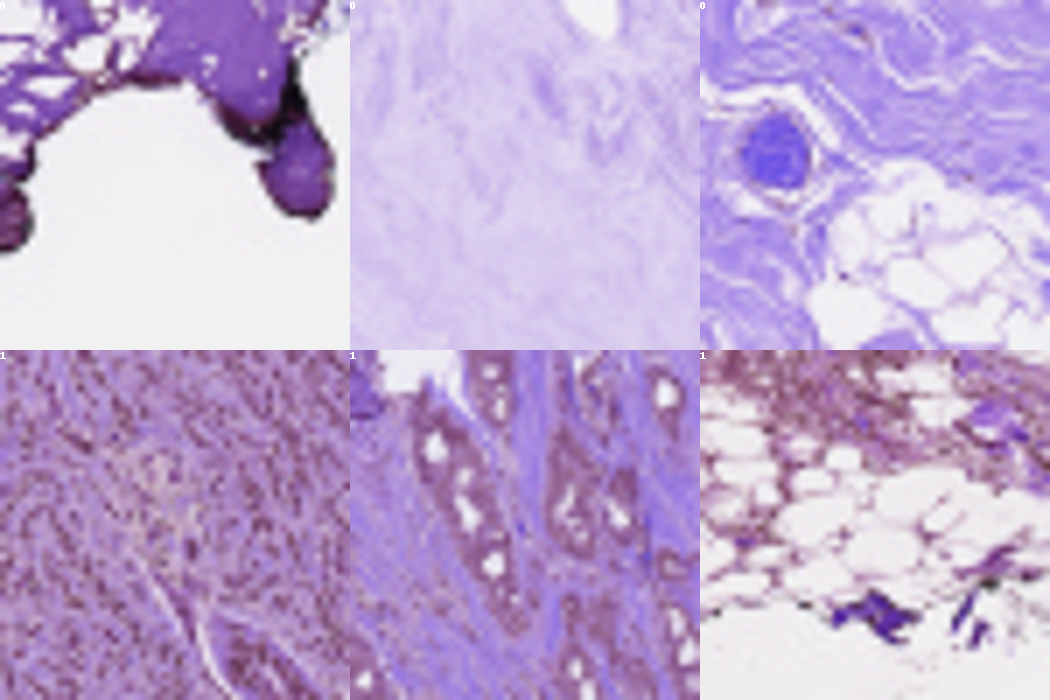

In [9]:
show_grid_of_examples(ds, seed=42, examples_per_class=3)

##### Basic Values/Constants

In [10]:
MODEL_CKPT = 'google/vit-large-patch32-384'
MODEL_NAME = MODEL_CKPT.split(f'/')[-1] + "-Breast_Histopathology_Images"

NUM_OF_EPOCHS = 2
LEARNING_RATE = 5e-3

STEPS = 150
BATCH_SIZE = 64

GRAD_ACC_STEPS = 4

DEVICE = torch.device("cuda")
REPORTS_TO = 'tensorboard'

##### Load ViT Feature Extractor

In [11]:
image_processor = ViTImageProcessor.from_pretrained(MODEL_CKPT)

#### Define Transformations For Both Training & Evaluation Datasets

In [12]:
normalize_image = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

train_transforms = Compose(
    [
        RandomResizedCrop(image_processor.size["height"]),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize_image,
    ]
)

eval_transforms = Compose(
    [
        Resize(image_processor.size["height"]),
        CenterCrop(image_processor.size["height"]),
        ToTensor(),
        normalize_image,
    ]
)

#### Define Functions to Apply Transformations to Datasets

In [13]:
def preprocess_train_dataset(sample_batch):
    """
    This method applies the train_transforms
    across a batch of training samples
    """
    sample_batch["pixel_values"] = [train_transforms(train_image.convert("RGB"))
                                    for train_image in sample_batch["image"]]
    return sample_batch


def preprocess_eval_dataset(sample_batch):
    """
    This method applies the eval_transforms
    across a batch of evaluation samples.
    """
    sample_batch["pixel_values"] = [eval_transforms(eval_image.convert("RGB"))
                                    for eval_image in sample_batch["image"]]
    return sample_batch

#### Apply Transform Functions to Dataset

In [14]:
prepped_train_ds = ds['train'].with_transform(preprocess_train_dataset)
prepped_eval_ds = ds['eval'].with_transform(preprocess_eval_dataset)

#### Define Function to Display Parameter Information

In [15]:
# Define Helper Function to Check Total Number of Model Parameters
# Also, return Number of Trainable Parameters

def print_parameters_information(model):
    trainable_parameters = 0
    all_parameters = 0

    for _, parameters in model.named_parameters():
        all_parameters += parameters.numel()
        if parameters.requires_grad:
            trainable_parameters += parameters.numel()

    print(f'Trainable Parameters: {trainable_parameters} ' + \
          f'|| All Parameters: {all_parameters} ' + \
          f'|| Trainable %: {round(trainable_parameters / all_parameters * 100, 2)}')

#### Define Data Collator

In [16]:
def data_collator(batch):
    return {
        'pixel_values' : torch.stack([x['pixel_values'] for x in batch]),
        'labels' : torch.tensor([x['labels'] for x in batch])
    }

#### Create List of Label Values & Dictionaries to Convert Between String & Integer Data Types

In [17]:
unique_label_values = ['non-IDC', 'IDC']

NUM_OF_LABELS = len(unique_label_values)

id2label = {str(i): c for i, c in enumerate(unique_label_values)}
label2id = {c: str(i) for i, c in enumerate(unique_label_values)}

print(f"List of Unique Label Values: \n{unique_label_values}\n")
print(f"Number of Unique Label Values: \n{NUM_OF_LABELS}\n")
print(f"id2label: \n{id2label}\n")
print(f"label2id: \n{label2id}")

List of Unique Label Values: 
['non-IDC', 'IDC']

Number of Unique Label Values: 
2

id2label: 
{'0': 'non-IDC', '1': 'IDC'}

label2id: 
{'non-IDC': '0', 'IDC': '1'}


##### Load Pretrained Model

In [18]:
model = ViTForImageClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=NUM_OF_LABELS,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
).to(DEVICE)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch32-384 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Print Original Parameters Information

In [19]:
print_parameters_information(model)

Trainable Parameters: 305609730 || All Parameters: 305609730 || Trainable %: 100.0


#### Define Function to Compute Metric

In [20]:
def compute_metrics(p):
    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)['accuracy']

    ### ------------------- F1 scores -------------------

    f1_score_metric = evaluate.load("f1")
    weighted_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["f1"]
    micro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')['f1']
    macro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["f1"]

    ### ------------------- recall -------------------

    recall_metric = evaluate.load("recall")
    weighted_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["recall"]
    micro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')["recall"]
    macro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["recall"]

    ### ------------------- precision -------------------

    precision_metric = evaluate.load("precision")
    weighted_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["precision"]
    micro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')["precision"]
    macro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["precision"]

    return {"accuracy" : accuracy,
            "Weighted F1" : weighted_f1_score,
            "Micro F1" : micro_f1_score,
            "Macro F1" : macro_f1_score,
            "Weighted Recall" : weighted_recall,
            "Micro Recall" : micro_recall,
            "Macro Recall" : macro_recall,
            "Weighted Precision" : weighted_precision,
            "Micro Precision" : micro_precision,
            "Macro Precision" : macro_precision
            }

#### Define PEFT Configuration

In [21]:
peft_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=['classifier']
)

#### Instantiate PEFT/LoRA Model

In [22]:
lora_model = get_peft_model(model, peft_config)

print_parameters_information(lora_model)

Trainable Parameters: 1576964 || All Parameters: 307184644 || Trainable %: 0.51


#### Define Training Arguments

In [23]:
args = TrainingArguments(
    output_dir=MODEL_NAME,
    remove_unused_columns=False,
    num_train_epochs=NUM_OF_EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    report_to=REPORTS_TO,
    disable_tqdm=False,
    logging_first_step=True,
    label_names=['labels'],
    gradient_accumulation_steps=GRAD_ACC_STEPS,
    hub_private_repo=True,
    fp16=True,
    push_to_hub=True
)

#### Instantiate Trainer

In [24]:
trainer = Trainer(
    model = lora_model,
    args = args,
    data_collator = data_collator,
    compute_metrics = compute_metrics,
    train_dataset = prepped_train_ds,
    eval_dataset = prepped_eval_ds,
    tokenizer = image_processor,
)

Cloning https://huggingface.co/DunnBC22/vit-large-patch32-384-Hyper_Kvasir_Labeled_Images into local empty directory.


#### Train Model

In [25]:
train_results = trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Weighted f1,Micro f1,Macro f1,Weighted recall,Micro recall,Macro recall,Weighted precision,Micro precision,Macro precision
0,0.353600,0.356763,0.845469,0.841122,0.845469,0.800268,0.845469,0.845469,0.786286,0.841092,0.845469,0.820524
1,0.441700,0.395421,0.820217,0.815068,0.820217,0.767427,0.820217,0.820217,0.754935,0.814136,0.820217,0.786001


#### Save & Log Model

In [26]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file adapter_model.bin:   1%|          | 32.0k/6.04M [00:00<?, ?B/s]

Upload file runs/Jul15_15-35-35_8991d5031230/events.out.tfevents.1689435340.8991d5031230.222.0: 100%|#########…

To https://huggingface.co/DunnBC22/vit-large-patch32-384-Hyper_Kvasir_Labeled_Images
   86e3f47..8ecf7a0  main -> main

   86e3f47..8ecf7a0  main -> main

To https://huggingface.co/DunnBC22/vit-large-patch32-384-Hyper_Kvasir_Labeled_Images
   8ecf7a0..577884e  main -> main

   8ecf7a0..577884e  main -> main



***** train metrics *****
  epoch                    =            2.0
  total_flos               = 252312512029GF
  train_loss               =         0.4052
  train_runtime            =     3:00:54.77
  train_samples_per_second =         30.622
  train_steps_per_second   =           0.12


#### Push Model to Hub (My Profile!)

In [27]:
kwargs = {
    "finetuned_from" : model.config._name_or_path,
    "tasks" : "image-classification",
    "tags" : ["image-classification"],
}

if args.push_to_hub:
    trainer.push_to_hub("All Dunn!!!")
else:
    trainer.create_model_card(**kwargs)

To https://huggingface.co/DunnBC22/vit-large-patch32-384-Hyper_Kvasir_Labeled_Images
   577884e..6f900a3  main -> main

   577884e..6f900a3  main -> main



### Notes & Other Takeaways
****
- I forgot to update the model name before fine-tuning this project. Both the name here and the name on the repository (in my HuggingFace Portfolio) are updated with the correct name.

- This project uses PEFT/LoRA to speed up fine-tuning as well as a larger version of the Vision Transformer checkpoint.

- I was expecting better results.

****

### Citations

- Model Checkpoint
  > @misc{wu2020visual, title={Visual Transformers: Token-based Image Representation and Processing for Computer Vision}, author={Bichen Wu and Chenfeng Xu and Xiaoliang Dai and Alvin Wan and Peizhao Zhang and Zhicheng Yan and Masayoshi Tomizuka and Joseph Gonzalez and Kurt Keutzer and Peter Vajda}, year={2020}, eprint={2006.03677}, archivePrefix={arXiv}, primaryClass={cs.CV}}

  > @inproceedings{deng2009imagenet, title={Imagenet: A large-scale hierarchical image database}, author={Deng, Jia and Dong, Wei and Socher, Richard and Li, Li-Jia and Li, Kai and Fei-Fei, Li}, booktitle={2009 IEEE conference on computer vision and pattern recognition}, pages={248--255}, year={2009}, organization={Ieee}}

- Dataset
  > The original data came from here: http://gleason.case.edu/webdata/jpi-dl-tutorial/IDC_regular_ps50_idx5.zip

  > https://www.ncbi.nlm.nih.gov/pubmed/27563488
  
  > http://spie.org/Publications/Proceedings/Paper/10.1117/12.2043872